In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import suppression as s
import utils
import linear_model

In [4]:
gaba_fn = 'gaba_data.txt'
supp_fn = 'supp_data_individual_20170427.txt'

In [5]:
sdf = utils.load_psychophys(supp_fn)
gdf = utils.load_gaba(gaba_fn)

In [6]:
plot_dir = "plots/redo-201809"

## Analyze tasks separately (before subsetting to include common subjects)##

In [7]:
pp_subjs = np.unique(sdf.Subject)
n_pp_subjs = len(pp_subjs)
gaba_subjs = np.unique(gdf.subjName)
n_gaba_subjs = len(gaba_subjs)
print(f"Psychophysics subjects (n={n_pp_subjs}):\n", pp_subjs)
print(f"GABA subjects (n={n_gaba_subjs}):\n", gaba_subjs)

Psychophysics subjects (n=37):
 ['ah' 'ai' 'am' 'ap' 'bi' 'bo' 'cl' 'cr' 'ct' 'dl' 'ds' 'eg' 'ei' 'em' 'es'
 'gd' 'gm' 'gw' 'jd' 'jv' 'ke' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'mv' 'nl' 'nn'
 'rn' 'sd' 'se' 'tj' 'tm' 'tt' 'yl']
GABA subjects (n=31):
 ['ac' 'ai' 'am' 'as' 'bi' 'ch' 'cr' 'cs' 'ct' 'dl' 'ei' 'em' 'es' 'gd' 'gm'
 'jd' 'jm' 'jv' 'ks' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'nl' 'ps' 'rn' 'sd' 'tt'
 'yl']


# GABA only analyses

### GABA t-test, CON v AMB

In [8]:
pop_group = gdf.groupby("Population")
pop_group.describe()

GABA                                                           
           count      mean       std    min     25%     50%      75%    max
Population                                                                 
Amblyope    16.0  0.202312  0.013385  0.179  0.1925  0.2025  0.21125  0.227
Control     15.0  0.206333  0.016482  0.173  0.1925  0.2110  0.21650  0.228

In [9]:
gaba_per_group = [col for col_name, col in pop_group['GABA']]
(tstat, pval) = st.ttest_ind(*gaba_per_group)
print(tstat, pval)

-0.747810754413 0.460595837907


** Thus we find no significant difference in GABA levels between CON and AMB. **

### GABA violin plot, all subjects

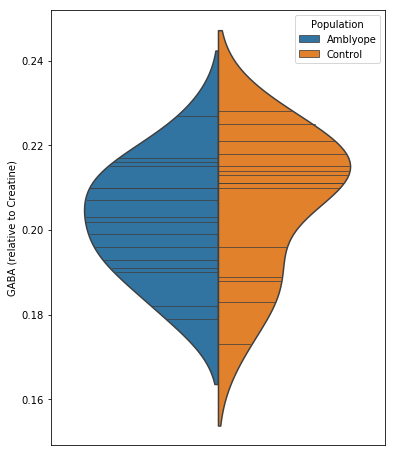

In [10]:
with s.PdfPages(f"{plot_dir}/gaba_diffs_n{n_gaba_subjs}.pdf") as pdf:
    fig = plt.figure(figsize=(6,8))  # create a figure object
    ax = fig.add_subplot(1, 1, 1)
    ax = sns.violinplot(y='GABA',x='Presentation',hue='Population',data=gdf,split=True,inner='stick',ax=ax)
    ax.xaxis.set_visible(False)
    ax.set_ylabel("GABA (relative to Creatine)")
    plt.show(ax.figure)
    pdf.savefig(ax.figure)
    plt.close(ax.figure)
    plt.close('all')

# Select one psychophysical task's data #

In [11]:
task = 'OS'
sdf = sdf[sdf['Task']==task]

In [12]:
df_to_model = sdf.copy() # make a deep copy

In [13]:
n_pp_subjs_thistask = len(np.unique(df_to_model.Subject))
n_amb_subjs_thistask = len(np.unique((df_to_model[df_to_model['Population']=='Amblyope'])['Subject']))
print(f"There are {n_pp_subjs_thistask} subjects for Task {task}, of which {n_amb_subjs_thistask} are Amblyopes.")

There are 36 subjects for Task OS, of which 13 are Amblyopes.


# Modeling

### Begin grouping data into conditions to model Subject's ThreshElev as a function of logRelContrast #

In [14]:
pp_gvars = ['Task','Orientation','Presentation','Population','Subject','Eye','Trace'] # One condition
pp_gvars_base = pp_gvars + ['BaselineThresh']

### Pick an xvalue (RelMaskContrast) to evaluate models at

2018-09-24: Abandoning Eunice's binning. Instead, try to figure out a good RelMaskContrast programatically.
 * Just looking at it (cell below), i'd say somewhere between 5 and 10 -- probably 6 (for SS) and 10 (for OS)

In [15]:
df_to_model.groupby([var for var in pp_gvars if var not in ["Subject"]])[["RelMaskContrast"]].describe(percentiles=[.25, .5, .6, .75])

RelMaskContrast  \
                                                                    count   
Task Orientation Presentation Population Eye Trace                          
OS   Cross       nDicho       Amblyope   De  Amblyope-De             51.0   
                                         Nde Amblyope-Nde            51.0   
                              Control    De  Control-De              51.0   
                                         Nde Control-Nde             91.0   
                 nMono        Amblyope   De  Amblyope-De             51.0   
                                         Nde Amblyope-Nde            51.0   
                              Control    De  Control-De              51.0   
                                         Nde Control-Nde             91.0   
     Iso         nDicho       Amblyope   De  Amblyope-De             50.0   
                                         Nde Amblyope-Nde            46.0   
                              Control    De  Control-De              51.0   
                                         Nde Control-Nde             88.0   
                 nMono        Amblyope   De  Amblyope-De             50.0   
                                         Nde Amblyope-Nde            50.0   
                              Control    De  Control-De              51.0   
                                         Nde Control-Nde             89.0   

                                                                      \
                                                                mean   
Task Orientation Presentation Population Eye Trace                     
OS   Cross       nDicho       Amblyope   De  Amblyope-De    9.989902   
                                         Nde Amblyope-Nde  13.507824   
                              Control    De  Control-De    13.208941   
                                         Nde Control-Nde   14.370659   
                 nMono        Amblyope   De  Amblyope-De   13.507824   
                                         Nde Amblyope-Nde   9.989902   
                              Control    De  Control-De    13.260588   
                                         Nde Control-Nde   14.341714   
     Iso         nDicho       Amblyope   De  Amblyope-De    9.499340   
                                         Nde Amblyope-Nde  11.506543   
                              Control    De  Control-De    13.208941   
                                         Nde Control-Nde   13.177841   
                 nMono        Amblyope   De  Amblyope-De   13.158600   
                                         Nde Amblyope-Nde   9.499340   
                              Control    De  Control-De    13.260588   
                                         Nde Control-Nde   13.422315   

                                                                             \
                                                                 std    min   
Task Orientation Presentation Population Eye Trace                            
OS   Cross       nDicho       Amblyope   De  Amblyope-De    8.360486  0.697   
                                         Nde Amblyope-Nde  10.098339  2.874   
                              Control    De  Control-De     8.957629  2.469   
                                         Nde Control-Nde   10.027643  2.039   
                 nMono        Amblyope   De  Amblyope-De   10.098339  2.874   
                                         Nde Amblyope-Nde   8.360486  0.697   
                              Control    De  Control-De     9.316148  2.039   
                                         Nde Control-Nde    9.847820  2.469   
     Iso         nDicho       Amblyope   De  Amblyope-De    7.668151  0.697   
                                         Nde Amblyope-Nde   7.812275  2.874   
                              Control    De  Control-De     8.957629  2.469   
                                         Nde Control-Nde    8.945252  2.039   
                 nMono        Amblyope  

In [16]:
xval_to_predict = {'SS': 6, 'OS': 10}

In [17]:
df_to_model['RelMCToPred'] = xval_to_predict[task]

In [18]:
groups = df_to_model.groupby(pp_gvars) 

### Linear model (defined in linear_model.py, uses lmfit)###

In [19]:
# initialize parameters
lm_params = linear_model.parameters()
preds_lm = groups.apply(utils.model_threshold, linear_model.err, linear_model.thresh, lm_params, ret='preds')

('OS', 'Cross', 'nDicho', 'Amblyope', 'ah', 'De', 'Amblyope-De')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.01093     -inf      inf   0.0158     True     None     None
y_int     1.664     -inf      inf   0.2981     True     None     None
('OS', 'Cross', 'nDicho', 'Amblyope', 'ah', 'De', 'Amblyope-De')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.01093     -inf      inf   0.0158     True     None     None
y_int     1.664     -inf      inf   0.2981     True     None     None
('OS', 'Cross', 'nDicho', 'Amblyope', 'ah', 'Nde', 'Amblyope-Nde')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.1093     -inf      inf  0.03274     True     None     None
y_int     2.168     -inf      inf   0.9295     True     None     None
('OS', 'Cross', 'nDicho', 'Amblyope', 'am', 'De', 'Amblyope-De')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.01333     -inf      

('OS', 'Cross', 'nDicho', 'Control', 'gw', 'Nde', 'Control-Nde')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.1838     -inf      inf  0.04531     True     None     None
y_int    0.5628     -inf      inf   0.5965     True     None     None
('OS', 'Cross', 'nDicho', 'Control', 'jd', 'De', 'Control-De')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.02891     -inf      inf 0.009449     True     None     None
y_int     1.067     -inf      inf    0.122     True     None     None
('OS', 'Cross', 'nDicho', 'Control', 'jd', 'Nde', 'Control-Nde')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope     0.135     -inf      inf 0.0008327     True     None     None
y_int    0.9016     -inf      inf  0.01187     True     None     None
('OS', 'Cross', 'nDicho', 'Control', 'ke', 'Nde', 'Control-Nde')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.0529     -inf      inf

('OS', 'Cross', 'nMono', 'Amblyope', 'gd', 'Nde', 'Amblyope-Nde')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.04064     -inf      inf 0.009012     True     None     None
y_int    0.6158     -inf      inf   0.1271     True     None     None
('OS', 'Cross', 'nMono', 'Amblyope', 'jv', 'De', 'Amblyope-De')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.04863     -inf      inf 0.005703     True     None     None
y_int    0.6607     -inf      inf  0.07105     True     None     None
('OS', 'Cross', 'nMono', 'Amblyope', 'jv', 'Nde', 'Amblyope-Nde')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.04471     -inf      inf  0.01152     True     None     None
y_int    0.5744     -inf      inf  0.08994     True     None     None
('OS', 'Cross', 'nMono', 'Amblyope', 'li', 'De', 'Amblyope-De')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.0414     -inf      in

('OS', 'Cross', 'nMono', 'Control', 'jd', 'Nde', 'Control-Nde')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.03055     -inf      inf 0.009581     True     None     None
y_int     0.681     -inf      inf   0.1237     True     None     None
('OS', 'Cross', 'nMono', 'Control', 'ke', 'Nde', 'Control-Nde')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.01617     -inf      inf 0.005083     True     None     None
y_int    0.7068     -inf      inf  0.08825     True     None     None
('OS', 'Cross', 'nMono', 'Control', 'kw', 'De', 'Control-De')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.04115     -inf      inf 0.004009     True     None     None
y_int    0.7036     -inf      inf  0.06468     True     None     None
('OS', 'Cross', 'nMono', 'Control', 'kw', 'Nde', 'Control-Nde')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.02149     -inf      inf  0.0

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.02597     -inf      inf  0.01602     True     None     None
y_int      1.35     -inf      inf   0.1027     True     None     None
('OS', 'Iso', 'nDicho', 'Amblyope', 'li', 'Nde', 'Amblyope-Nde')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.1336     -inf      inf   0.0275     True     None     None
y_int     8.993     -inf      inf   0.2882     True     None     None
('OS', 'Iso', 'nDicho', 'Amblyope', 'mg', 'De', 'Amblyope-De')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.5439     -inf      inf 0.004766     True     None     None
y_int     1.186     -inf      inf  0.08112     True     None     None
('OS', 'Iso', 'nDicho', 'Amblyope', 'mg', 'Nde', 'Amblyope-Nde')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.6116     -inf      inf   0.1304     True     None     None
y_int      3.31     -inf     

('OS', 'Iso', 'nDicho', 'Control', 'ls', 'De', 'Control-De')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope     1.578     -inf      inf   0.2387     True     None     None
y_int    -2.514     -inf      inf    2.307     True     None     None
('OS', 'Iso', 'nDicho', 'Control', 'ls', 'Nde', 'Control-Nde')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope      1.14     -inf      inf  0.09227     True     None     None
y_int    -1.561     -inf      inf    1.013     True     None     None
('OS', 'Iso', 'nDicho', 'Control', 'mk', 'De', 'Control-De')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.7907     -inf      inf   0.2659     True     None     None
y_int     2.299     -inf      inf    2.708     True     None     None
('OS', 'Iso', 'nDicho', 'Control', 'mk', 'Nde', 'Control-Nde')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.5874     -inf      inf 0.009325  

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.1165     -inf      inf  0.02476     True     None     None
y_int     2.074     -inf      inf   0.3458     True     None     None
('OS', 'Iso', 'nMono', 'Amblyope', 'mv', 'Nde', 'Amblyope-Nde')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.1814     -inf      inf  0.09588     True     None     None
y_int     1.318     -inf      inf    1.597     True     None     None
('OS', 'Iso', 'nMono', 'Amblyope', 'rn', 'De', 'Amblyope-De')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.08854     -inf      inf  0.05602     True     None     None
y_int    0.5143     -inf      inf   0.5952     True     None     None
('OS', 'Iso', 'nMono', 'Amblyope', 'rn', 'Nde', 'Amblyope-Nde')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.2093     -inf      inf 0.009597     True     None     None
y_int    0.1782     -inf      in

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.1512     -inf      inf   0.1011     True     None     None
y_int     1.572     -inf      inf     1.03     True     None     None
('OS', 'Iso', 'nMono', 'Control', 'ms', 'De', 'Control-De')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.03458     -inf      inf   0.0168     True     None     None
y_int     1.147     -inf      inf   0.3307     True     None     None
('OS', 'Iso', 'nMono', 'Control', 'ms', 'Nde', 'Control-Nde')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.08086     -inf      inf 0.002197     True     None     None
y_int    0.9793     -inf      inf  0.04779     True     None     None
('OS', 'Iso', 'nMono', 'Control', 'nl', 'De', 'Control-De')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.0433     -inf      inf 0.002871     True     None     None
y_int    0.6831     -inf      inf  0.036

### Linear model, this time using statsmodels -- use to verify previous implementation was correct

In [20]:
df_to_model.columns

Index(['Subject', 'Task', 'Presentation', 'Orientation', 'Eye', 'Population',
       'MaskContrast', 'ThreshElev', 'ThreshElev_SE', 'RelMaskContrast',
       'Trace', 'BaselineThresh', 'BinCenterRelMaskContrast', 'BinNumber',
       'logThreshElev', 'RelMCToPred'],
      dtype='object')

In [21]:
import statsmodels.formula.api as sm

for gv, g in groups:
    result = sm.ols(formula="ThreshElev ~ RelMaskContrast", data=g).fit()
    print(gv, result.params, sep="\n")

('OS', 'Cross', 'nDicho', 'Amblyope', 'ah', 'De', 'Amblyope-De')
Intercept          1.663579
RelMaskContrast    0.010934
dtype: float64
('OS', 'Cross', 'nDicho', 'Amblyope', 'ah', 'Nde', 'Amblyope-Nde')
Intercept          2.168488
RelMaskContrast    0.109311
dtype: float64
('OS', 'Cross', 'nDicho', 'Amblyope', 'am', 'De', 'Amblyope-De')
Intercept          0.939042
RelMaskContrast    0.013325
dtype: float64
('OS', 'Cross', 'nDicho', 'Amblyope', 'am', 'Nde', 'Amblyope-Nde')
Intercept          1.049379
RelMaskContrast    0.017715
dtype: float64
('OS', 'Cross', 'nDicho', 'Amblyope', 'bi', 'De', 'Amblyope-De')
Intercept          0.910471
RelMaskContrast    0.022884
dtype: float64
('OS', 'Cross', 'nDicho', 'Amblyope', 'bi', 'Nde', 'Amblyope-Nde')
Intercept          5.436084
RelMaskContrast    0.792939
dtype: float64
('OS', 'Cross', 'nDicho', 'Amblyope', 'cl', 'De', 'Amblyope-De')
Intercept          0.743895
RelMaskContrast    0.044875
dtype: float64
('OS', 'Cross', 'nDicho', 'Amblyope', 'cl'

('OS', 'Cross', 'nMono', 'Amblyope', 'rn', 'De', 'Amblyope-De')
Intercept          0.837608
RelMaskContrast    0.035344
dtype: float64
('OS', 'Cross', 'nMono', 'Amblyope', 'rn', 'Nde', 'Amblyope-Nde')
Intercept          0.714693
RelMaskContrast    0.033355
dtype: float64
('OS', 'Cross', 'nMono', 'Amblyope', 'sd', 'De', 'Amblyope-De')
Intercept          0.998512
RelMaskContrast    0.056011
dtype: float64
('OS', 'Cross', 'nMono', 'Amblyope', 'sd', 'Nde', 'Amblyope-Nde')
Intercept          1.025604
RelMaskContrast   -0.097892
dtype: float64
('OS', 'Cross', 'nMono', 'Amblyope', 'tt', 'De', 'Amblyope-De')
Intercept          0.466437
RelMaskContrast    0.041436
dtype: float64
('OS', 'Cross', 'nMono', 'Amblyope', 'tt', 'Nde', 'Amblyope-Nde')
Intercept          0.759614
RelMaskContrast    0.015099
dtype: float64
('OS', 'Cross', 'nMono', 'Control', 'ai', 'De', 'Control-De')
Intercept          0.406470
RelMaskContrast    0.053249
dtype: float64
('OS', 'Cross', 'nMono', 'Control', 'ai', 'Nde', 'C

Intercept         -0.254912
RelMaskContrast    1.006515
dtype: float64
('OS', 'Iso', 'nDicho', 'Control', 'ke', 'Nde', 'Control-Nde')
Intercept         -3.139910
RelMaskContrast    1.314523
dtype: float64
('OS', 'Iso', 'nDicho', 'Control', 'kw', 'De', 'Control-De')
Intercept         -1.259062
RelMaskContrast    0.928764
dtype: float64
('OS', 'Iso', 'nDicho', 'Control', 'kw', 'Nde', 'Control-Nde')
Intercept          0.128384
RelMaskContrast    0.996790
dtype: float64
('OS', 'Iso', 'nDicho', 'Control', 'ls', 'De', 'Control-De')
Intercept         -2.513833
RelMaskContrast    1.577783
dtype: float64
('OS', 'Iso', 'nDicho', 'Control', 'ls', 'Nde', 'Control-Nde')
Intercept         -1.560743
RelMaskContrast    1.140357
dtype: float64
('OS', 'Iso', 'nDicho', 'Control', 'mk', 'De', 'Control-De')
Intercept          2.298800
RelMaskContrast    0.790726
dtype: float64
('OS', 'Iso', 'nDicho', 'Control', 'mk', 'Nde', 'Control-Nde')
Intercept          3.839718
RelMaskContrast    0.587410
dtype: float

** Note on column names: **
 * RelMaskContrast is the presented MaskContrast (absolute, in C%) divided by the subject's BaselineThresh
 * ThreshElev is the *observed* threshold elevation at that RelMaskContrast
 * ThreshPred is the *model's predicted* threshold elevation at that RelMaskContrast
 * RelMCToPred is the RelMaskContrast that is the center of the bin with the biggest NDE/DE difference (BinNumberToPred)

In [22]:
preds_lm.columns

Index(['Subject', 'Task', 'Presentation', 'Orientation', 'Eye', 'Population',
       'MaskContrast', 'ThreshElev', 'ThreshElev_SE', 'RelMaskContrast',
       'Trace', 'BaselineThresh', 'BinCenterRelMaskContrast', 'BinNumber',
       'logThreshElev', 'RelMCToPred', 'ThreshPred'],
      dtype='object')

### Plot the regression lines 

In [23]:
s.group_facet_plots(preds_lm, s.subject_fit_plot,
                    f"{plot_dir}/{task}_regressions_combinedplots_n{n_pp_subjs_thistask}_TOP.pdf",
                    ['Task','Orientation','Presentation'], #each combo of this gets its own page
                    row='Population',col='Eye',# facet rows and columns
                    x="RelMaskContrast", y="ThreshElev", # x, y
                    hue="Subject",yerr='ThreshElev_SE',fmt_obs='.',fmt_pred='x:',Ycol="ThreshPred") 

Plotting OS.Cross.nDicho
Plotting OS.Cross.nMono
Plotting OS.Iso.nDicho
Plotting OS.Iso.nMono
Plots saved at plots/redo-201809/OS_regressions_combinedplots_n36_TOP.pdf


In [24]:
s.group_facet_plots(preds_lm, s.population_fit_plot,
                    f"{plot_dir}/{task}_regressions_combinedplots_n{n_pp_subjs_thistask}_TO.pdf",
                    ['Task','Orientation'], #each combo of this gets its own page
                    row='Presentation',col='Eye',# facet rows and columns
                    x="RelMaskContrast", y="ThreshElev", # x, y
                    hue="Population",yerr='ThreshElev_SE',fmt_obs='.',fmt_pred='x:',Ycol="ThreshPred") 

Plotting OS.Cross
Plotting OS.Iso
Plots saved at plots/redo-201809/OS_regressions_combinedplots_n36_TO.pdf


### Conclusions from these regression plots (_TO):
 * SS: looks fine, esp with new binning (IMO).
 * OS: one or two subjects really messes up the axes. One bc of a huge error bar on their observed ThreshElev, one but v low predicted ThreshElev by model; exclude? Both are controls so part of the larger group.
   * This only happens in Iso-orientation, which is different from Cross in substantial ways. What does that indicate?

### Model the data again, but this time return parameters, not predictions ###

In [25]:
print(pp_gvars_base)
pp_gvars_base_mcpred = pp_gvars_base + ['RelMCToPred']
groups_with_baseline_mcpred = df_to_model.groupby(pp_gvars_base_mcpred)

['Task', 'Orientation', 'Presentation', 'Population', 'Subject', 'Eye', 'Trace', 'BaselineThresh']


In [26]:
pfit = groups_with_baseline_mcpred.apply(utils.model_threshold, linear_model.err, linear_model.thresh, lm_params, ret='weights').reset_index()

('OS', 'Cross', 'nDicho', 'Amblyope', 'ah', 'De', 'Amblyope-De', 1.4350000000000001, 10)
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.01093     -inf      inf   0.0158     True     None     None
y_int     1.664     -inf      inf   0.2981     True     None     None
('OS', 'Cross', 'nDicho', 'Amblyope', 'ah', 'De', 'Amblyope-De', 1.4350000000000001, 10)
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.01093     -inf      inf   0.0158     True     None     None
y_int     1.664     -inf      inf   0.2981     True     None     None
('OS', 'Cross', 'nDicho', 'Amblyope', 'ah', 'Nde', 'Amblyope-Nde', 2.1590000000000003, 10)
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.1093     -inf      inf  0.03274     True     None     None
y_int     2.168     -inf      inf   0.9295     True     None     None
('OS', 'Cross', 'nDicho', 'Amblyope', 'am', 'De', 'Amblyope-De', 2.1840000000000002, 10)
Name  

y_int    0.6499     -inf      inf   0.4016     True     None     None
('OS', 'Cross', 'nDicho', 'Control', 'cr', 'Nde', 'Control-Nde', 1.456, 10)
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.04616     -inf      inf 0.008639     True     None     None
y_int     1.776     -inf      inf   0.2385     True     None     None
('OS', 'Cross', 'nDicho', 'Control', 'ct', 'De', 'Control-De', 3.2949999999999999, 10)
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.1027     -inf      inf  0.09214     True     None     None
y_int     1.137     -inf      inf   0.9269     True     None     None
('OS', 'Cross', 'nDicho', 'Control', 'ct', 'Nde', 'Control-Nde', 3.395, 10)
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.03922     -inf      inf 0.002473     True     None     None
y_int     1.981     -inf      inf  0.02564     True     None     None
('OS', 'Cross', 'nDicho', 'Control', 'dl', 'De', 'Contr

('OS', 'Cross', 'nDicho', 'Control', 'tm', 'De', 'Control-De', 1.653, 10)
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.07129     -inf      inf  0.01242     True     None     None
y_int     1.003     -inf      inf   0.2292     True     None     None
('OS', 'Cross', 'nDicho', 'Control', 'tm', 'Nde', 'Control-Nde', 1.571, 10)
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.2006     -inf      inf  0.05703     True     None     None
y_int     1.195     -inf      inf        1     True     None     None
('OS', 'Cross', 'nDicho', 'Control', 'yl', 'De', 'Control-De', 2.1600000000000001, 10)
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.05148     -inf      inf  0.02837     True     None     None
y_int     1.786     -inf      inf   0.5413     True     None     None
('OS', 'Cross', 'nDicho', 'Control', 'yl', 'Nde', 'Control-Nde', 1.79, 10)
Name      Value      Min      Max   Stderr     Vary 

y_int    0.4664     -inf      inf   0.2099     True     None     None
('OS', 'Cross', 'nMono', 'Amblyope', 'tt', 'Nde', 'Amblyope-Nde', 1.7380000000000002, 10)
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.0151     -inf      inf 0.007202     True     None     None
y_int    0.7596     -inf      inf   0.1429     True     None     None
('OS', 'Cross', 'nMono', 'Control', 'ai', 'De', 'Control-De', 2.6069999999999998, 10)
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.05325     -inf      inf  0.00137     True     None     None
y_int    0.4065     -inf      inf  0.01523     True     None     None
('OS', 'Cross', 'nMono', 'Control', 'ai', 'Nde', 'Control-Nde', 3.2360000000000002, 10)
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope  0.007915     -inf      inf  0.03111     True     None     None
y_int     1.199     -inf      inf   0.2787     True     None     None
('OS', 'Cross', 'nMono', 'Cont

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.02034     -inf      inf 0.0004544     True     None     None
y_int     1.235     -inf      inf   0.0078     True     None     None
('OS', 'Cross', 'nMono', 'Control', 'nn', 'Nde', 'Control-Nde', 2.036, 10)
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.04103     -inf      inf 0.008095     True     None     None
y_int    0.6372     -inf      inf   0.1371     True     None     None
('OS', 'Cross', 'nMono', 'Control', 'se', 'De', 'Control-De', 3.1339999999999999, 10)
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.01614     -inf      inf   0.0038     True     None     None
y_int    0.9165     -inf      inf  0.04141     True     None     None
('OS', 'Cross', 'nMono', 'Control', 'se', 'Nde', 'Control-Nde', 2.508, 10)
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.05342     -inf      inf  0.03352     True    

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.03553     -inf      inf  0.01058     True     None     None
y_int     1.438     -inf      inf   0.1473     True     None     None
('OS', 'Iso', 'nDicho', 'Amblyope', 'tt', 'Nde', 'Amblyope-Nde', 1.7380000000000002, 10)
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope     1.656     -inf      inf    0.362     True     None     None
y_int     3.177     -inf      inf    4.524     True     None     None
('OS', 'Iso', 'nDicho', 'Control', 'ai', 'De', 'Control-De', 2.6069999999999998, 10)
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope     1.596     -inf      inf   0.3914     True     None     None
y_int    -3.537     -inf      inf    3.506     True     None     None
('OS', 'Iso', 'nDicho', 'Control', 'ai', 'Nde', 'Control-Nde', 3.2360000000000002, 10)
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope     1.451     -inf      i

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.2148     -inf      inf    0.105     True     None     None
y_int   -0.3649     -inf      inf    1.338     True     None     None
('OS', 'Iso', 'nDicho', 'Control', 'nn', 'Nde', 'Control-Nde', 2.036, 10)
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope     1.226     -inf      inf   0.2126     True     None     None
y_int    -3.793     -inf      inf      3.6     True     None     None
('OS', 'Iso', 'nDicho', 'Control', 'se', 'De', 'Control-De', 3.1339999999999999, 10)
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.4874     -inf      inf  0.02467     True     None     None
y_int   -0.2728     -inf      inf    0.336     True     None     None
('OS', 'Iso', 'nDicho', 'Control', 'se', 'Nde', 'Control-Nde', 2.508, 10)
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.4712     -inf      inf 0.003755     True     Non

('OS', 'Iso', 'nMono', 'Amblyope', 'tt', 'Nde', 'Amblyope-Nde', 1.7380000000000002, 10)
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.09237     -inf      inf   0.0266     True     None     None
y_int     1.155     -inf      inf   0.3705     True     None     None
('OS', 'Iso', 'nMono', 'Control', 'ai', 'De', 'Control-De', 2.6069999999999998, 10)
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope     0.195     -inf      inf  0.03044     True     None     None
y_int   0.05168     -inf      inf   0.3385     True     None     None
('OS', 'Iso', 'nMono', 'Control', 'ai', 'Nde', 'Control-Nde', 3.2360000000000002, 10)
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.1924     -inf      inf  0.05835     True     None     None
y_int    0.4411     -inf      inf   0.5227     True     None     None
('OS', 'Iso', 'nMono', 'Control', 'ap', 'Nde', 'Control-Nde', 2.4790000000000001, 10)
Name      Value     

slope    0.2828     -inf      inf  0.07524     True     None     None
y_int    -1.413     -inf      inf     1.33     True     None     None
('OS', 'Iso', 'nMono', 'Control', 'tm', 'De', 'Control-De', 1.653, 10)
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.1854     -inf      inf   0.0369     True     None     None
y_int     1.102     -inf      inf    0.647     True     None     None
('OS', 'Iso', 'nMono', 'Control', 'tm', 'Nde', 'Control-Nde', 1.571, 10)
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.1251     -inf      inf   0.0113     True     None     None
y_int    0.2682     -inf      inf   0.2085     True     None     None
('OS', 'Iso', 'nMono', 'Control', 'yl', 'De', 'Control-De', 2.1600000000000001, 10)
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.1268     -inf      inf 0.007451     True     None     None
y_int    0.5419     -inf      inf   0.1178     True     None     N

In [27]:
pfit.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,RelMCToPred,y_int,slope
0,OS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,1.435,10,1.663579,0.010934
1,OS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,2.159,10,2.168488,0.109311
2,OS,Cross,nDicho,Amblyope,am,De,Amblyope-De,2.184,10,0.939042,0.013325
3,OS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,2.670,10,1.049378,0.017715
4,OS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,1.668,10,0.910471,0.022884


In [28]:
pfit.groupby(["Orientation", "Presentation", "Population", "Eye", "RelMCToPred"]).describe()

BaselineThresh            \
                                                             count      mean   
Orientation Presentation Population Eye RelMCToPred                            
Cross       nDicho       Amblyope   De  10                    13.0  1.739692   
                                    Nde 10                    13.0  2.978769   
                         Control    De  10                    15.0  2.379800   
                                    Nde 10                    23.0  2.290739   
            nMono        Amblyope   De  10                    13.0  1.739692   
                                    Nde 10                    13.0  2.978769   
                         Control    De  10                    15.0  2.379800   
                                    Nde 10                    23.0  2.290739   
Iso         nDicho       Amblyope   De  10                    13.0  1.739692   
                                    Nde 10                    13.0  2.978769   
                         Control    De  10                    15.0  2.379800   
                                    Nde 10                    23.0  2.290739   
            nMono        Amblyope   De  10                    13.0  1.739692   
                                    Nde 10                    13.0  2.978769   
                         Control    De  10                    15.0  2.379800   
                                    Nde 10                    23.0  2.290739   

                                                                              \
                                                          std    min     25%   
Orientation Presentation Population Eye RelMCToPred                            
Cross       nDicho       Amblyope   De  10           0.389979  1.229  1.4350   
                                    Nde 10           1.693849  1.110  2.0070   
                         Control    De  10           0.624081  1.574  1.8435   
                                    Nde 10           0.578011  1.456  1.8190   
            nMono        Amblyope   De  10           0.389979  1.229  1.4350   
                                    Nde 10           1.693849  1.110  2.0070   
                         Control    De  10           0.624081  1.574  1.8435   
                                    Nde 10           0.578011  1.456  1.8190   
Iso         nDicho       Amblyope   De  10           0.389979  1.229  1.4350   
                                    Nde 10           1.693849  1.110  2.0070   
                         Control    De  10           0.624081  1.574  1.8435   
                                    Nde 10           0.578011  1.456  1.8190   
            nMono        Amblyope   De  10           0.389979  1.229  1.4350   
                                    Nde 10           1.693849  1.110  2.0070   
                         Control    De  10           0.624081  1.574  1.8435   
                                    Nde 10           0.578011  1.456  1.8190   

                                                                          \
                                                       50%    75%    max   
Orientation Presentation Population Eye RelMCToPred                        
Cross       nDicho       Amblyope   De  10           1.668  1.937  2.454   
                                    Nde 10           2.444  2.706  7.171   
                         Control    De  10           2.275  2.782  3.433   
                                    Nde 10           2.136  2.801  3.395   
            nMono        Amblyope   De  10           1.668  1.937  2.454   
                                    Nde 10           2.444  2.706  7.171   
                         Control    De  10           2.275  2.782  3.433   
                                    Nde 10           2.136  2.801  3.395   
Iso         nDicho       Amblyope   De  10           1.668  1.937  2.454   
                                    Nde 10           2.444  2.706  7.171   
                      

In [29]:
pfit['ThreshPredCritical'] = pfit['y_int'] + pfit['slope'] * pfit['RelMCToPred']
pfit['ThreshPredCriticalUnnorm'] = pfit['ThreshPredCritical'] * pfit['BaselineThresh']

### Depth of suppression measures ("how far from ThreshElev=1?")

In [30]:
pfit['DepthOfSuppressionPred'] = (-1) + pfit['ThreshPredCritical']

In [31]:
# melt the result of the modeling into long format for plotting
pfit_all_ppsub = pd.melt(pfit, id_vars=pp_gvars, var_name='measure')
pfit_all_ppsub.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,measure,value
0,OS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,BaselineThresh,1.435
1,OS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,BaselineThresh,2.159
2,OS,Cross,nDicho,Amblyope,am,De,Amblyope-De,BaselineThresh,2.184
3,OS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,BaselineThresh,2.670
4,OS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,BaselineThresh,1.668


## Subset to include only (GABA and psychophyics) subjects

In [32]:
gaba_and_pp_subjs = list(np.intersect1d(pp_subjs, gaba_subjs))
n_gaba_and_pp_subjs = len(gaba_and_pp_subjs)

In [33]:
sdf = sdf[sdf.Subject.isin(gaba_and_pp_subjs)] # only subjects who did _the current_ pp task and GABA
gaba_and_pp_subjs_thistask = np.unique(sdf.Subject)
n_gaba_and_pp_subjs_thistask = len(gaba_and_pp_subjs_thistask)
print(f"Of the {n_gaba_and_pp_subjs} subjects with both GABA and psychophysics data, {n_gaba_and_pp_subjs_thistask} have both for task {task}.")

Of the 24 subjects with both GABA and psychophysics data, 23 have both for task OS.


In [34]:
gdf = gdf[gdf.subjName.isin(sdf.Subject)] # only subjects who did both tasks
print(f"Of the {len(gdf)} subjects with GABA and {task} data, {len(gdf[gdf.Population=='Amblyope'])} are Amblyopes.")
n_this_task = len(gdf)

Of the 23 subjects with GABA and OS data, 9 are Amblyopes.


## Combine Psychophysics and GABA below

In [35]:
#Grab the GABA measure for each subject and append it to each observation for easy plotting
comb = pfit_all_ppsub.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])
print(len(comb))

#subset to include only those subjects with GABA data
comb_gabappsub = comb[~np.isnan(comb['GABA'])]
print(len(comb_gabappsub), f"{len(np.unique(comb_gabappsub.Subject))} subjects")

1792
1260 23 subjects


In [36]:
comb_gabappsub.head(n=10)

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,measure,value,GABA
2,OS,Cross,nDicho,Amblyope,am,De,Amblyope-De,BaselineThresh,2.184,0.193
3,OS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,BaselineThresh,2.670,0.193
4,OS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,BaselineThresh,1.668,0.207
5,OS,Cross,nDicho,Amblyope,bi,Nde,Amblyope-Nde,BaselineThresh,2.706,0.207
10,OS,Cross,nDicho,Amblyope,gd,De,Amblyope-De,BaselineThresh,2.454,0.203
11,OS,Cross,nDicho,Amblyope,gd,Nde,Amblyope-Nde,BaselineThresh,2.444,0.203
12,OS,Cross,nDicho,Amblyope,jv,De,Amblyope-De,BaselineThresh,1.484,0.215
13,OS,Cross,nDicho,Amblyope,jv,Nde,Amblyope-Nde,BaselineThresh,2.367,0.215
14,OS,Cross,nDicho,Amblyope,li,De,Amblyope-De,BaselineThresh,2.310,0.227
15,OS,Cross,nDicho,Amblyope,li,Nde,Amblyope-Nde,BaselineThresh,5.381,0.227


In [37]:
np.unique(comb_gabappsub.measure)

array(['BaselineThresh', 'DepthOfSuppressionPred', 'RelMCToPred',
       'ThreshPredCritical', 'ThreshPredCriticalUnnorm', 'slope', 'y_int'], dtype=object)

In [38]:
#graphs!
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_n{n_this_task}_linear.pdf") as pdf:
    plot_groups = comb_gabappsub.groupby(['Task','Orientation','measure'])
    for gv, gr in plot_groups:
        print(gv, np.all(np.isnan(gr['value'])))
        #print(gr.columns)
        #if gv[0]=='SS' and gv[1]=='Cross': continue
        g2 = s.gaba_vs_psychophys_plot_2line(gv, gr)
        pdf.savefig(g2.fig)
        #g4 = s.gaba_vs_psychophys_plot_4line(gv, gr)
        #pdf.savefig(g4.fig)
        
    plt.close('all')

('OS', 'Cross', 'BaselineThresh') False
('OS', 'Cross', 'DepthOfSuppressionPred') False
('OS', 'Cross', 'RelMCToPred') False
('OS', 'Cross', 'ThreshPredCritical') False
('OS', 'Cross', 'ThreshPredCriticalUnnorm') False
('OS', 'Cross', 'slope') False
('OS', 'Cross', 'y_int') False
('OS', 'Iso', 'BaselineThresh') False
('OS', 'Iso', 'DepthOfSuppressionPred') False
('OS', 'Iso', 'RelMCToPred') False
('OS', 'Iso', 'ThreshPredCritical') False
('OS', 'Iso', 'ThreshPredCriticalUnnorm') False
('OS', 'Iso', 'slope') False
('OS', 'Iso', 'y_int') False


### Conclusions from the graphs we just generated
#### SS, but using old bins initially; updated with new bins info:
 * BaselineThresh
    * There is a negative relationship between GABA and BaselineThresh for both eyes, both populations, both surround conditions. This is an interesting finding in itself...
      * (nDicho and nMono are identical since this is baseline thresh, ie just one eye)
      * new bins: this remains true.
 * DepthOfSuppression
    * In SS/Cross/Dicho, more GABA = less suppression of NDE, but = more suppression of DE. This is especially true of Amblyopes, while in Controls the effect is weak/insignificant.
      * new bins: this remains true, and the positive slope of GABA vs suppression for the DE is higher in nMono than nDicho -- what does this mean?
    * In SS/Iso/Dicho, more GABA = less suppression of NDE, = more suppression of DE. Effect is very strong for Amblyopes and absent for other conditions(AMB/Mono and all Controls)
      * new bins: still true
 * Critical Bin Center (RelMCToPred)
    * In SS/Cross/Dicho the NDE has a higher (numerically, in multiples of baseline) RelMCToPred for both AMB and CON
    * But in SS/Cross/Mono it's the reverse, DE has higher RelMCToPred for both populations
    * new bins: this measure is rendered obsolete since I handpicked an x-val
 * ThreshPredCritical
    * For both Cross and Iso, Dicho/AMB shows biggest difference b/t NDE and DE in predicted threshold elevation. Other conditions show little to no difference.
    * new bins: now seeing this effect in AMB/nMono, similar to DepthofSuppression
 * ThreshPredCriticalUnnorm
    * When we normalize by each eye's baseline, this effect is still present.
    * new bins: still true, and unlike baseline-normalized ThreshPredCritical, effect not present in nMono (ie same pattern as with the old bins)
 * Linear model slope
    * AMB/Dicho shows biggest difference between trends in each eye for both presentation conditions. more GABA ~ lower slope of the line for NDE, while DE is basically flat.
    * new bins: nMono shows effect too, AMB look v different than controls, esp in Dicho.
 * Linear model y-int
    * AMB/Dicho has opposite GABA vs y-int slopes for both Iso and Cross, but the distributions overlap for all conditions and populations, so this is a weak finding.
    * new bins: same
    
#### OS, new bins
 * BaselineThresh
   * no strong trends vs GABA for either Iso or Cross.
 * DepthOfSuppression
   * Cross: positive slope for NDE in all conditions, much stronger in Dicho. DE flat in all, p much.
   * Iso: negative slope for NDE in AMB/Dicho. Positive/flat slopes in other conditions, and for De slopes 
 * Critical Bin Center (RelMCToPred): handpicked
 * ThreshPredCritical
   * Cross: NDE positive, DE flat-ish, least CI overlap in AMB/Dicho
   * Iso: everything overlaps a lot. least so in AMB/Dicho (NDE vs DE)
 * ThreshPredCriticalUnnorm
   * Cross: Same as normalized, but bigger diff/less overlap in AMB/Dicho than normalized.
   * Iso: everything overlaps a lot. least so in AMB/Dicho
 * Linear model slope
   * Cross: basically all flat, except nMono/AMB/NDE? Weak/nonexistent/CI overlappy tho.
   * Iso: Trending opposite DE/NDE but all overlap a lot
 * Linear model y-int
   * Cross: NDE slopes positive (for both AMB and CON, but higher magnitude for AMB), least overlap in AMB/Dicho
   * NDE vs DE trend similar in Dicho but opposite in Mono (for both Con and AMB), but lots of overlap


### Combine measures across the two eyes

 * Does it make sense to combine all measures across both eyes (i.e. by subtracting?) For example, ThreshElev is in units of baseline, and the baseline varies by eye. So perhaps only a few measures should be combined -- say, slope/yint, ThreshPredCriticalUnnorm. 

In [39]:
#subset to include only these measures:
# - baseline threshold
# - unnormalized predicted threshold elevation at critical bin center
# - slope of ThreshElev ~ RelMaskContrast line
# - y-int of this line
measures = comb_gabappsub[comb_gabappsub["measure"].isin(["BaselineThresh","ThreshPredCritical","slope","y_int"])]
#print(len(comb_all_ppsub))

In [40]:
np.unique(measures.measure)

array(['BaselineThresh', 'ThreshPredCritical', 'slope', 'y_int'], dtype=object)

In [41]:
paired_obs = measures.groupby(['Task', 'Orientation', 'Population', 'Presentation', 'Subject', 'measure'])

def get_eyediff_value(g):
    if len(g)==2: # this will exclude paired observations where there was no data for one eye
        value_diff = g[g['Eye']=='Nde'].value.iat[0] - g[g['Eye']=='De'].value.iat[0]
        #print(g.name, value_diff)
        return pd.Series([value_diff], ['Nde-De'])

In [42]:
obs_diff = paired_obs.apply(get_eyediff_value).reset_index()

In [43]:
obs_diff.head(n=6)

,Task,Orientation,Population,Presentation,Subject,measure,Nde-De
0,OS,Cross,Amblyope,nDicho,am,BaselineThresh,0.486000
1,OS,Cross,Amblyope,nDicho,am,ThreshPredCritical,0.154230
2,OS,Cross,Amblyope,nDicho,am,slope,0.004389
3,OS,Cross,Amblyope,nDicho,am,y_int,0.110337
4,OS,Cross,Amblyope,nDicho,bi,BaselineThresh,1.038000
5,OS,Cross,Amblyope,nDicho,bi,ThreshPredCritical,12.226166


In [44]:
comb_botheyes = obs_diff.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])

In [45]:
comb_botheyes.head()

,Task,Orientation,Population,Presentation,Subject,measure,Nde-De,GABA
0,OS,Cross,Amblyope,nDicho,am,BaselineThresh,0.486000,0.193
1,OS,Cross,Amblyope,nDicho,am,ThreshPredCritical,0.154230,0.193
2,OS,Cross,Amblyope,nDicho,am,slope,0.004389,0.193
3,OS,Cross,Amblyope,nDicho,am,y_int,0.110337,0.193
4,OS,Cross,Amblyope,nDicho,bi,BaselineThresh,1.038000,0.207


In [46]:
print(len(np.unique(comb_botheyes.Subject)))

23


In [47]:
#graphs!
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_combeyes_n{n_this_task}.pdf") as pdf:
    plot_groups = comb_botheyes.groupby(['Task','Orientation','measure'])
    for gv, gr in plot_groups:
        print(gv)
        g2 = s.gaba_vs_psychophys_plot_2line_2eye(gv, gr)
        pdf.savefig(g2.fig)
        
    plt.close('all')

('OS', 'Cross', 'BaselineThresh')
('OS', 'Cross', 'ThreshPredCritical')
('OS', 'Cross', 'slope')
('OS', 'Cross', 'y_int')
('OS', 'Iso', 'BaselineThresh')
('OS', 'Iso', 'ThreshPredCritical')
('OS', 'Iso', 'slope')
('OS', 'Iso', 'y_int')


In [48]:
# more graphs for presentation!
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_combeyes_n{n_this_task}_condensed.pdf") as pdf:
    plot_groups = comb_botheyes.groupby(['Task','measure'])
    for gv, gr in plot_groups:
        print(gv)
        if gv[-1] not in ["BaselineThresh", "RelMCToPred"]: # use this line to exclude measures we don't want
            g2 = s.gaba_vs_psychophys_plot_2line_2eye(gv, gr, row="Orientation", size=8, aspect=1.2)
            #print(g2.axes)
            pdf.savefig(g2.fig)
        
    plt.close('all')

('OS', 'BaselineThresh')
('OS', 'ThreshPredCritical')
('OS', 'slope')
('OS', 'y_int')


### Conclusions from Interocular suppression graphs
#### SS, new bins
 * Interocular difference measures all seem to get back to “the two eyes of amblyopes are more different than the two eyes of controls, and the magnitude of this difference is inversely related to GABA).
   * This is interesting and we want to present it, right?
#### OS, new bins:
 * Some strong effects in y-int Iso in both Dicho and esp. Mono. Cross is a wash
 * Other measures look fairly similar?

### Orientation-selective suppression can go here

 * We should start off by doing each eye separately, right? So, starting from comb_gabappsub df.
 * Or if we started from the combined-eye data generated above, use measures df.

In [49]:
oss_gvars = ["Task", "Presentation", "Population", "Subject", "Eye", "Trace", "measure", "GABA"]

In [50]:
def calculate_orientation_selective_suppression(df, **kwargs):
    #print(df[['Orientation', 'value']])
    iso_cross_oss_ratio = df[df.Orientation=='Iso']['value'].iloc[0]/df[df.Orientation=='Cross']['value'].iloc[0]
    print(f"Iso/Cross ratio: {iso_cross_oss_ratio}")
    return pd.Series(iso_cross_oss_ratio, ['value'])
    #print(df[df['Orientation'=='Cross']]) #/df[df['Orientation'=='Cross']]['value']

In [51]:
oss_df = comb_gabappsub.groupby(oss_gvars).apply(calculate_orientation_selective_suppression).reset_index()

Iso/Cross ratio: 1.0
Iso/Cross ratio: 1.0
Iso/Cross ratio: 6.2536519042621705
Iso/Cross ratio: 1.0
Iso/Cross ratio: 1.3542043867776123
Iso/Cross ratio: 1.3542043867776126
Iso/Cross ratio: 2.4182982855356534
Iso/Cross ratio: 1.2032058434215527
Iso/Cross ratio: 1.0
Iso/Cross ratio: 64.62167336306024
Iso/Cross ratio: 1.0
Iso/Cross ratio: 12.750192625225031
Iso/Cross ratio: 12.750192625225031
Iso/Cross ratio: 59.342503240043854
Iso/Cross ratio: 4.884896700605914
Iso/Cross ratio: 1.0
Iso/Cross ratio: 94.15851669643882
Iso/Cross ratio: 1.0
Iso/Cross ratio: 12.391228297521266
Iso/Cross ratio: 12.391228297521266
Iso/Cross ratio: 72.0094572754436
Iso/Cross ratio: -2.593464862665468
Iso/Cross ratio: 1.0
Iso/Cross ratio: 0.8784449847745514
Iso/Cross ratio: 1.0
Iso/Cross ratio: 0.8875396847401223
Iso/Cross ratio: 0.8875396847401223
Iso/Cross ratio: 1.5162642477053463
Iso/Cross ratio: -0.02955515345498405
Iso/Cross ratio: 1.0
Iso/Cross ratio: 21.208906470868506
Iso/Cross ratio: 1.0
Iso/Cross ratio:

Iso/Cross ratio: 1.5885310094684049
Iso/Cross ratio: 2.1140703034970674
Iso/Cross ratio: 1.2417635152808182
Iso/Cross ratio: 1.0
Iso/Cross ratio: 6.735230345958089
Iso/Cross ratio: 1.0
Iso/Cross ratio: 1.7350328184492996
Iso/Cross ratio: 1.7350328184492996
Iso/Cross ratio: 3.484752552747989
Iso/Cross ratio: 0.4473900508977092
Iso/Cross ratio: 1.0
Iso/Cross ratio: 45.89658371751018
Iso/Cross ratio: 1.0
Iso/Cross ratio: 1.943033670951141
Iso/Cross ratio: 1.943033670951141
Iso/Cross ratio: 4.263964174212467
Iso/Cross ratio: 0.13660693857597797
Iso/Cross ratio: 1.0
Iso/Cross ratio: 6.142057616247226
Iso/Cross ratio: 1.0
Iso/Cross ratio: 2.619019715345233
Iso/Cross ratio: 2.619019715345233
Iso/Cross ratio: 1.3806564329909163
Iso/Cross ratio: 3.109414251098272
Iso/Cross ratio: 1.0
Iso/Cross ratio: 11.93289044262868
Iso/Cross ratio: 1.0
Iso/Cross ratio: 2.5658638959353612
Iso/Cross ratio: 2.5658638959353612
Iso/Cross ratio: 5.1464435515040785
Iso/Cross ratio: 2.0767279874466484
Iso/Cross rati

In [52]:
oss_df.head()

,Task,Presentation,Population,Subject,Eye,Trace,measure,GABA,value
0,OS,nDicho,Amblyope,am,De,Amblyope-De,BaselineThresh,0.193,1.000000
1,OS,nDicho,Amblyope,am,De,Amblyope-De,DepthOfSuppressionPred,0.193,6.253652
2,OS,nDicho,Amblyope,am,De,Amblyope-De,RelMCToPred,0.193,1.000000
3,OS,nDicho,Amblyope,am,De,Amblyope-De,ThreshPredCritical,0.193,1.354204
4,OS,nDicho,Amblyope,am,De,Amblyope-De,ThreshPredCriticalUnnorm,0.193,1.354204


In [53]:
oss_df.columns

Index(['Task', 'Presentation', 'Population', 'Subject', 'Eye', 'Trace',
       'measure', 'GABA', 'value'],
      dtype='object')

In [54]:
#graphs!
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_oss_n{n_this_task}.pdf") as pdf:
    plot_groups = oss_df.groupby(['Task','measure'])
    for gv, gr in plot_groups:
        if gv[-1] not in ["BaselineThresh", "RelMCToPred"]:
            print(gv, np.all(np.isnan(gr['value'])))
            g2 = s.gaba_vs_oss_plot_2line(gv, gr)
            pdf.savefig(g2.fig)
        
    plt.close('all')

('OS', 'DepthOfSuppressionPred') False
('OS', 'ThreshPredCritical') False
('OS', 'ThreshPredCriticalUnnorm') False
('OS', 'slope') False
('OS', 'y_int') False


### Conclusions from these graphs:
#### SS new and old bins, they're all the same
 * The two eyes seem to not be that different in their Iso/Cross ratios of the various measures.

#### OS new bins
 * NDE vs DE Iso/Cross ratios often trend different relative to GABA, but CIs overlap.